In [5]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [6]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [44]:
from parameters import *
from lib.utils import *
from lib.attacks import *
from lib.keras_utils import *

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [8]:
from keras.datasets import mnist

x_train, y_train, x_test, y_test = load_dataset_mnist()

y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

### 2-class vs N-class DNN

In [98]:
a = 3
b = 7

x_train_ab = x_train[[y == a or y == b for y in y_train]]
y_train_ab = y_train[[y == a or y == b for y in y_train]]
y_train_ab[y_train_ab == a] = 0
y_train_ab[y_train_ab == b] = 1
y_train_ab_cat = keras.utils.to_categorical(y_train_ab)

x_test_ab = x_test[[y == a or y == b for y in y_test]]
y_test_ab = y_test[[y == a or y == b for y in y_test]]
y_test_ab[y_test_ab == a] = 0
y_test_ab[y_test_ab == b] = 1
y_test_ab_cat = keras.utils.to_categorical(y_test_ab)

model = build_cnn_mnist_2cls()
model.fit(x_train_ab, y_train_ab_cat,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test_ab, y_test_ab_cat))
score = model.evaluate(x_test_ab, y_test_ab_cat, verbose=0)
print(score)

Train on 12396 samples, validate on 2038 samples
Epoch 1/10
12396/12396 [==============================] - 2s 130us/step - loss: 0.0945 - acc: 0.9674 - val_loss: 0.0473 - val_acc: 0.9823
Epoch 2/10
12396/12396 [==============================] - 1s 74us/step - loss: 0.0321 - acc: 0.9894 - val_loss: 0.0437 - val_acc: 0.9848
Epoch 3/10
12396/12396 [==============================] - 1s 74us/step - loss: 0.0205 - acc: 0.9935 - val_loss: 0.0165 - val_acc: 0.9926
Epoch 4/10
12396/12396 [==============================] - 1s 73us/step - loss: 0.0159 - acc: 0.9948 - val_loss: 0.0139 - val_acc: 0.9941
Epoch 5/10
12396/12396 [==============================] - 1s 73us/step - loss: 0.0107 - acc: 0.9966 - val_loss: 0.0121 - val_acc: 0.9946
Epoch 6/10
12396/12396 [==============================] - 1s 73us/step - loss: 0.0091 - acc: 0.9969 - val_loss: 0.0083 - val_acc: 0.9980
Epoch 7/10
12396/12396 [==============================] - 1s 69us/step - loss: 0.0074 - acc: 0.9975 - val_loss: 0.0106 - val_acc

In [114]:
x_adv = PGD(model, x_test_ab[:1000], y_test_ab[:1000], grad_fn=None, norm="inf", 
            n_step=10, step_size=0.01, target=False, init_rnd=0.1)

Finished 200 samples in 4.26s.
Finished 400 samples in 3.74s.
Finished 600 samples in 3.84s.
Finished 800 samples in 3.85s.


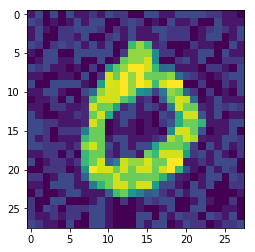

In [67]:
plt.imshow(x_adv[1].reshape(28,28))

In [115]:
model.evaluate(x_adv, y_test_ab_cat[:1000])

1000/1000 [==============================] - 0s 73us/step


[0.672608332157135, 0.807]

In [14]:
model = build_cnn_mnist()
model.load_weights('./tmp/weights/mnist_cnn_smxe.h5')

In [94]:
acc = []
for n_step in range(5, 55, 5):
    x_adv = PGD(model, x_test, y_test, grad_fn=None, norm="inf", 
                n_step=n_step, step_size=0.01, target=False, init_rnd=0.)
    acc.append(model.evaluate(x_adv, y_test_ab_cat, verbose=0))

Finished 200 samples in 12.16s.
Finished 400 samples in 11.57s.
Finished 600 samples in 11.60s.
Finished 800 samples in 11.87s.


In [95]:
model.evaluate(x_adv, y_test_cat[:1000])

1000/1000 [==============================] - 0s 76us/step


[4.454765869140625, 0.1]

In [96]:
np.mean(np.linalg.norm((x_adv - x_test[:1000]).reshape(-1, 784), axis=-1, ord=np.inf))

0.30000004

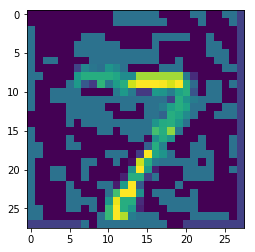

In [97]:
plt.imshow(x_adv[0].reshape(28,28))

In [161]:
path = './tmp/num_class_experiment/'
# clean_acc = pickle.load(open(path + 'clean_acc.p', 'rb'))
adv_acc = pickle.load(open(path + 'adv_acc.p', 'rb'))

In [162]:
acc = np.zeros(10)
for a in adv_acc:
    for i in range(10):
        acc[i] += a[i][1]
acc /= len(adv_acc)

In [165]:
adv_acc = pickle.load(open(path + '10cls_acc.p', 'rb'))

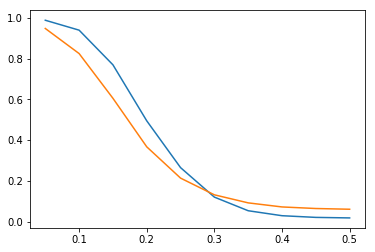

In [166]:
eps = np.arange(0.05, 0.55, 0.05)
plt.plot(eps, acc)
plt.plot(eps, [x[1] for x in adv_acc])

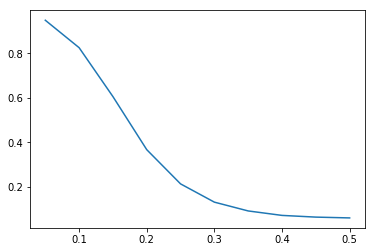

In [160]:
eps = np.arange(0.05, 0.55, 0.05)
plt.plot(eps, [x[1] for x in adv_acc])

--- 
## Gaussian Ball Experiment

Generate dataset

In [80]:
path = './data/gauss/'
n = 70000
n_train = 60000
d = 500

mean_a = np.zeros(d)
mean_b = np.ones(d)
std = np.sqrt(d) / 6.  # touching at 3 std
x_a = np.random.normal(loc=mean_a, scale=std, 
                       size=(int(n/2), d))
x_b = np.random.normal(loc=mean_b, scale=std, 
                       size=(int(n/2), d))
x = np.concatenate([x_a, x_b])
y = np.concatenate(([0] * int(n/2), [1] * int(n/2)))
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=n_train)

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
pickle.dump([x_train, y_train, x_test, y_test], 
            open('{}d{}.p'.format(path, d), 'wb'), protocol=4)

Load dataset

In [9]:
data_path = './data/gauss/'
path = './tmp/gauss/'
d = 500
x_train, y_train, x_test, y_test = pickle.load(
    open('{}d{}.p'.format(data_path, d), 'rb'))
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

In [95]:
model_100 = build_dnn_baseline(100)
model_500 = build_dnn_baseline(500)

In [44]:
model.fit(x_train[:5000], y_train_cat[:5000],
          batch_size=50,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test_cat))

Train on 5000 samples, validate on 10000 samples
Epoch 1/10
5000/5000 [==============================] - 2s 408us/step - loss: 0.1357 - acc: 0.9438 - val_loss: 0.0273 - val_acc: 0.9908
Epoch 2/10
5000/5000 [==============================] - 1s 228us/step - loss: 0.0100 - acc: 0.9982 - val_loss: 0.0198 - val_acc: 0.9932
Epoch 3/10
5000/5000 [==============================] - 1s 216us/step - loss: 0.0067 - acc: 0.9986 - val_loss: 0.0172 - val_acc: 0.9942
Epoch 4/10
5000/5000 [==============================] - 1s 221us/step - loss: 0.0037 - acc: 0.9998 - val_loss: 0.0151 - val_acc: 0.9948
Epoch 5/10
5000/5000 [==============================] - 1s 213us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9949
Epoch 6/10
5000/5000 [==============================] - 1s 220us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9951
Epoch 7/10
5000/5000 [==============================] - 1s 222us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9953

In [17]:
model.save_weights('./tmp/gauss/weights_d{}_baseline.h5'.format(d))

In [83]:
model.load_weights('./tmp/gauss/weights_d{}_baseline.h5'.format(d))

In [84]:
x_adv = PGD(model, x_test[:100], y_test[:100], grad_fn=None, norm="inf", 
            n_step=50, step_size=0.01, target=False, init_rnd=0.)

In [64]:
model.evaluate(x_adv, y_test_cat[:100])

100/100 [==============================] - 0s 990us/step


[4.575765495300293, 0.44]

In [72]:
model.evaluate(x_adv, y_test_cat[:100])

100/100 [==============================] - 0s 1ms/step


[3.740817346572876, 0.41]

In [76]:
for i in range(20):
    print(np.where(x_adv[i] - x_test[i] > 0))

(array([47]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]),)
(array([ 0,  1,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 87, 88, 89,
       90, 91, 92, 93, 95, 96, 97, 98, 99]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27

In [87]:
np.linalg.norm(x_adv - x_test[:100], axis=1, ord=np.inf)

array([0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999999,
       0.49999999, 0.49999999, 0.49999999, 0.49999999, 0.49999

In [21]:
adv_acc1 = pickle.load(open(path + 'adv_acc_d100_baseline.p', 'rb'))
adv_acc2 = pickle.load(open(path + 'adv_acc_d500_baseline.p', 'rb'))

In [38]:
adv_acc1[1]

[0.984, 0.9464, 0.8605, 0.717, 0.5213, 0.3136, 0.1568, 0.0611, 0.0193, 0.0049]

In [33]:
adv_acc2[1]

[0.9893, 0.9541, 0.8666, 0.7254, 0.5238, 0.319, 0.161, 0.066, 0.0188, 0.0045]

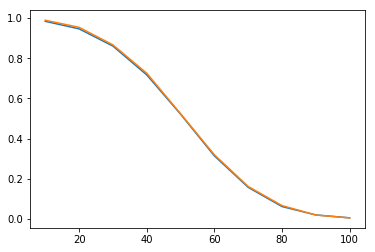

In [59]:
plt.plot(adv_acc1[0], adv_acc1[1])
plt.plot(adv_acc2[0], adv_acc2[1])

#### Model Complexity
Linear SVM

In [198]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1., intercept_scaling=1e4)
svm.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=10000.0, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [199]:
svm.score(x_test, y_test)

0.9985

In [116]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
svm = LinearSVC(C=1.)
svm.fit(x_train_pca, y_train)
svm.score(pca.transform(x_test), y_test)

0.9982

In [121]:
eps_list = np.arange(0.1, 1.1, 0.1) * 50
adv_acc = []

x_test_pca = pca.transform(x_test)
for eps in eps_list:
    grad = svm.coef_[0]
    x_adv = np.zeros_like(x_test_pca)

    for i, (x, y) in enumerate(zip(x_test_pca, y_test)):
        if not y:
            x_adv[i] = x + np.sign(grad) * eps
        else:
            x_adv[i] = x - np.sign(grad) * eps

    adv_acc.append(svm.score(x_adv, y_test))

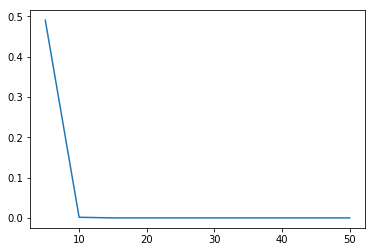

In [122]:
plt.plot(eps_list, adv_acc)

In [119]:
svm.coef_

array([[0.97958851, 0.00972365]])

In [99]:
svm.score(x_test, y_test)

0.9975

In [200]:
eps_list = np.arange(0.1, 1.1, 0.1)
adv_acc = []

for eps in eps_list:
    grad = svm.coef_[0]
    x_adv = np.zeros_like(x_test)

    for i, (x, y) in enumerate(zip(x_test, y_test)):
        if not y:
            x_adv[i] = x + np.sign(grad) * eps
        else:
            x_adv[i] = x - np.sign(grad) * eps

    adv_acc.append(svm.score(x_adv, y_test))

In [201]:
adv_acc

[0.9915, 0.9633, 0.8819, 0.726, 0.502, 0.2793, 0.1221, 0.0392, 0.0087, 0.0016]

In [196]:
adv_acc

[0.9866,
 0.9548,
 0.8612,
 0.7084,
 0.4977,
 0.2897,
 0.1378,
 0.0513,
 0.0125,
 0.0022]

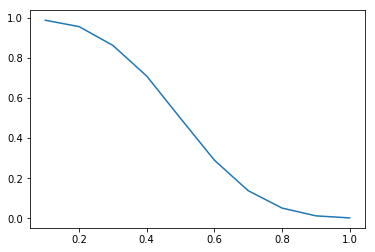

In [195]:
plt.plot(eps_list, adv_acc)

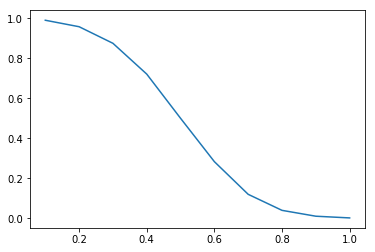

In [141]:
plt.plot(eps_list, adv_acc)

In [203]:
svm.intercept_

array([-1.56052449])

In [202]:
np.sum(svm.coef_)

3.275094463213529

In [205]:
np.sum(svm.coef_ > 0)

500

In [96]:
w500 = svm.coef_

Changing depths (no hidden (~ logistic regression), 2, 4, 8)

In [12]:
model = Sequential()
model.add(Dense(2, input_dim=d, activation='linear'))
model.compile(loss=output_fn,
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

In [11]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [14]:
model.fit(x_train, y_train_cat,
          batch_size=50,
          epochs=100,
          verbose=1,
          callbacks=[earlystop],
          validation_data=(x_test, y_test_cat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 58us/step - loss: 0.3392 - acc: 0.8800 - val_loss: 0.1230 - val_acc: 0.9792
Epoch 2/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.0845 - acc: 0.9905 - val_loss: 0.0616 - val_acc: 0.9937
Epoch 3/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.0459 - acc: 0.9958 - val_loss: 0.0376 - val_acc: 0.9960
Epoch 4/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.0289 - acc: 0.9971 - val_loss: 0.0258 - val_acc: 0.9966
Epoch 5/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0198 - acc: 0.9980 - val_loss: 0.0187 - val_acc: 0.9973
Epoch 6/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0145 - acc: 0.9983 - val_loss: 0.0146 - val_acc: 0.9975
Epoch 7/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0112 - acc: 0.9984 - val_loss: 0.0120 - 

In [15]:
model.save_weights('{}weights_d{}_depth{}.h5'.format(path, d, 0))

In [ ]:
model.load_weights('{}weights_d{}_depth{}.h5'.format(path, d, 0))

In [16]:
steps = np.array(range(10, 110, 10))
for n_step in steps:
    x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="inf",
                n_step=n_step, step_size=0.01, target=False, init_rnd=0.)
    score = model.evaluate(x_adv, y_test_cat[:200])
    print(score[1])

200/200 [==============================] - 0s 51us/step
0.985
200/200 [==============================] - 0s 47us/step
0.965
200/200 [==============================] - 0s 61us/step
0.87
200/200 [==============================] - 0s 55us/step
0.73
200/200 [==============================] - 0s 68us/step
0.47
200/200 [==============================] - 0s 66us/step
0.255
200/200 [==============================] - 0s 80us/step
0.25
200/200 [==============================] - 0s 59us/step
0.105
200/200 [==============================] - 0s 64us/step
0.015
200/200 [==============================] - 0s 64us/step
0.01


In [18]:
for depth in [1, 2, 4, 8]:
    model = Sequential()
    model.add(Dense(1000, input_dim=d, activation='relu'))
    model.add(BatchNormalization())
    for _ in range(depth - 1):
        model.add(Dense(1000, activation='relu'))
        model.add(BatchNormalization())
    model.add(Dense(2, activation='linear'))
    model.compile(loss=output_fn,
                  optimizer=keras.optimizers.Adam(lr=1e-4),
                  metrics=['accuracy'])
    model.fit(x_train, y_train_cat,
              batch_size=50,
              epochs=50,
              verbose=1,
              callbacks=[earlystop],
              validation_data=(x_test, y_test_cat))
    model.save_weights('{}weights_d{}_depth{}.h5'.format(path, d, depth))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 122us/step - loss: 0.0229 - acc: 0.9919 - val_loss: 0.0079 - val_acc: 0.9975
Epoch 2/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.0089 - acc: 0.9970 - val_loss: 0.0079 - val_acc: 0.9976
Epoch 3/50
60000/60000 [==============================] - 6s 97us/step - loss: 0.0072 - acc: 0.9977 - val_loss: 0.0083 - val_acc: 0.9969
Epoch 4/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.0063 - acc: 0.9978 - val_loss: 0.0078 - val_acc: 0.9974
Epoch 5/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.0056 - acc: 0.9980 - val_loss: 0.0067 - val_acc: 0.9977
Epoch 6/50
60000/60000 [==============================] - 6s 101us/step - loss: 0.0049 - acc: 0.9982 - val_loss: 0.0078 - val_acc: 0.9974
Epoch 7/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.0037 - acc: 0.9985 - val_loss: 0.0063 - va

Changing width (40, 200, 1000, 5000)

In [19]:
for width in [40, 200, 1000, 5000]:
    model = Sequential()
    model.add(Dense(width, input_dim=d, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(width, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='linear'))
    model.compile(loss=output_fn,
                  optimizer=keras.optimizers.Adam(lr=1e-4),
                  metrics=['accuracy'])
    model.fit(x_train, y_train_cat,
              batch_size=50,
              epochs=50,
              verbose=1,
              callbacks=[earlystop],
              validation_data=(x_test, y_test_cat))
    model.save_weights('{}weights_d{}_width{}.h5'.format(path, d, width))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 180us/step - loss: 0.1699 - acc: 0.9320 - val_loss: 0.0332 - val_acc: 0.9924
Epoch 2/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0292 - acc: 0.9915 - val_loss: 0.0150 - val_acc: 0.9962
Epoch 3/50
60000/60000 [==============================] - 9s 150us/step - loss: 0.0174 - acc: 0.9949 - val_loss: 0.0104 - val_acc: 0.9970
Epoch 4/50
60000/60000 [==============================] - 9s 146us/step - loss: 0.0144 - acc: 0.9952 - val_loss: 0.0087 - val_acc: 0.9969
Epoch 5/50
60000/60000 [==============================] - 9s 148us/step - loss: 0.0120 - acc: 0.9959 - val_loss: 0.0079 - val_acc: 0.9973
Epoch 6/50
60000/60000 [==============================] - 9s 147us/step - loss: 0.0116 - acc: 0.9959 - val_loss: 0.0074 - val_acc: 0.9974
Epoch 7/50
60000/60000 [==============================] - 9s 150us/step - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0072 -

In [20]:
model.evaluate(x_test, y_test_cat)

10000/10000 [==============================] - 1s 79us/step


[0.013215170873210053, 0.9963]

Training set size (0.01, 0.1, 0.5, 2, 5)

In [173]:
path = './tmp/gauss/'

In [167]:
model1 = Sequential()
model1.add(Dense(1000, input_dim=d, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(1000, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(2, activation='linear'))
model1.compile(loss=output_fn,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

In [168]:
model2 = Sequential()
model2.add(Dense(2000, input_dim=d, activation='relu'))
model2.add(BatchNormalization())
for _ in range(4):
    model2.add(Dense(2000, activation='relu'))
    model2.add(BatchNormalization())
model2.add(Dense(2, activation='linear'))
model2.compile(loss=output_fn,
              optimizer=keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

In [12]:
for r in [0.1]:
    
    model = build_dnn_wd(d, 1600, 4) 
    x_t, _, y_t, _ = train_test_split(x_train, y_train, train_size=r)
    y_t_cat = keras.utils.to_categorical(y_t)
    
    model.fit(x_t, y_t_cat,
               batch_size=50,
               epochs=50,
               verbose=1,
               callbacks=[earlystop],
               validation_data=(x_test, y_test_cat))
    #model.save_weights('{}weights_d{}_L_train{}.h5'.format(path, d, r))
    print(model.evaluate(x_test, y_test_cat))

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 6000 samples, validate on 10000 samples
Epoch 1/50
6000/6000 [==============================] - 4s 717us/step - loss: 0.0901 - acc: 0.9630 - val_loss: 0.0276 - val_acc: 0.9903
Epoch 2/50
6000/6000 [==============================] - 2s 302us/step - loss: 0.0088 - acc: 0.9967 - val_loss: 0.0208 - val_acc: 0.9930
Epoch 3/50
6000/6000 [==============================] - 2s 297us/step - loss: 0.0047 - acc: 0.9992 - val_loss: 0.0214 - val_acc: 0.9930
Epoch 4/50
6000/6000 [==============================] - 2s 288us/step - loss: 0.0062 - acc: 0.9973 - val_loss: 0.0305 - val_acc: 0.9906
Epoch 5/50
6000/6000 [==============================] - 2s 316us/step - loss: 0.0062 - acc: 0.9982 - val_loss: 0.0288 - val_acc: 0.9920
Epoch 6/50
6000/6000 [==============================] - 2s 291us/step - loss: 0.0023 - acc: 0.9990 - val_loss: 0.0299 - val_acc: 0.9926
Epoch 7/50
10000/10000 [==============================] - 1s 77us/step
[0.02893858062393292, 0.992]


In [190]:
model.load_weights('{}weights_d{}_L_train{}.h5'.format(path, d, 0.01))

In [215]:
steps = np.array(range(10, 110, 10))
for n_step in steps:
    x_adv = PGD(model, x_test[:200], y_test[:200], grad_fn=None, norm="inf",
                n_step=n_step, step_size=0.01, target=False, init_rnd=0.)
    score = model.evaluate(x_adv, y_test_cat[:200])
    print(score[1])

200/200 [==============================] - 0s 134us/step
0.95
200/200 [==============================] - 0s 116us/step
0.88
200/200 [==============================] - 0s 104us/step
0.8
200/200 [==============================] - 0s 114us/step
0.635
200/200 [==============================] - 0s 103us/step
0.435
200/200 [==============================] - 0s 102us/step
0.225
200/200 [==============================] - 0s 97us/step
0.135
200/200 [==============================] - 0s 100us/step
0.045
200/200 [==============================] - 0s 102us/step
0.015
200/200 [==============================] - 0s 102us/step
0.0


In [ ]:
steps = np.array(range(10, 110, 10))
for n_step in steps:
    x_adv = PGD(model, x_t[:200], y_t[:200], grad_fn=None, norm="inf",
                n_step=n_step, step_size=0.01, target=False, init_rnd=0.)
    score = model.evaluate(x_adv, y_t_cat[:200])
    print(score[1])

200/200 [==============================] - 0s 91us/step
0.995
200/200 [==============================] - 0s 109us/step
0.985
200/200 [==============================] - 0s 109us/step
0.86
200/200 [==============================] - 0s 102us/step
0.69
200/200 [==============================] - 0s 100us/step
0.52
200/200 [==============================] - 0s 110us/step
0.345
200/200 [==============================] - 0s 107us/step
0.195
200/200 [==============================] - 0s 101us/step
0.11


In [ ]:
[0.9893, 0.9541, 0.8666, 0.7254, 0.5238, 0.319, 0.161, 0.066, 0.0188, 0.0045]

In [211]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 1600)              801600    
_________________________________________________________________
batch_normalization_60 (Batc (None, 1600)              6400      
_________________________________________________________________
dense_82 (Dense)             (None, 1600)              2561600   
_________________________________________________________________
batch_normalization_61 (Batc (None, 1600)              6400      
_________________________________________________________________
dense_83 (Dense)             (None, 1600)              2561600   
_________________________________________________________________
batch_normalization_62 (Batc (None, 1600)              6400      
_________________________________________________________________
dense_84 (Dense)             (None, 1600)              2561600   
__________

Regularization

## Uniform spheres

In [21]:
path = './data/sphere/'
n = 70000
n_train = 60000
d = 500

r = 1
R = 1.3
x = np.random.normal(loc=0, scale=1, size=(n, d))
x /= np.linalg.norm(x, axis=1, keepdims=True)
x[:n//2] *= r
x[n//2:] *= R
y = np.concatenate(([0] * (n//2), [1] * (n//2)))
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=n_train)

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [32]:
pickle.dump([x_train, y_train, x_test, y_test], 
            open('{}sphere_d{}.p'.format(path, d), 'wb'), protocol=4)

In [34]:
data_path = './data/sphere/'
path = './tmp/sphere/'
d = 500
x_train, y_train, x_test, y_test = pickle.load(
    open('{}sphere_d{}.p'.format(data_path, d), 'rb'))
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

In [40]:
model = build_dnn_baseline(d)

In [ ]:
model.fit(x_train, y_train_cat,
          batch_size=50,
          epochs=50,
          verbose=1,
          callbacks=[earlystop, checkpoint],
          validation_data=(x_test, y_test_cat))
model = load_model('./tmp.h5')
model.evaluate(x_train, y_train_cat)
model.evaluate(x_test, y_test_cat)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
31600/60000 [==============>...............] - ETA: 3s - loss: 0.0025 - acc: 0.9992

In [42]:
checkpoint = keras.callbacks.ModelCheckpoint(
    './tmp.h5', save_best_only=True, period=1)